<center><h1>DSCI-552 HOMEWORK 8</h1>
<br>
<font size="3">Name: Vorapoom Thirapatarapong</font>
<br>
<font size="3">USC ID: 4397330150 Github Username: bvorapoom</font></center>

#### import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, confusion_matrix, calinski_harabasz_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans, SpectralClustering
from scipy.special import softmax
from sklearn.exceptions import FitFailedWarning
import warnings
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier


# 1. Supervised, Semi-Supervised, and Unsupervised Learning

#### 1-(a). Download the Breast Cancer Wisconsin (Diagnostic) Data Set from: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+ %28Diagnostic%29. Download the data in https://archive.ics.uci.edu/ml/ machine-learning-databases/breast-cancer-wisconsin/wdbc.data, which has IDs, classes (Benign=B, Malignant=M), and 30 attributes. This data has two output classes.

In [2]:
# column names for dataset
col_name_wdbc = ['id', 'class']
temp_col = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', \
            'concave_points', 'symmetry', 'fractal_dimension']
col_name_wdbc = col_name_wdbc + [col + '_' + str(i) for i in range(1, 4) for col in temp_col]

In [3]:
df_wdbc = pd.DataFrame(columns = col_name_wdbc)

with open('../data/wdbc.data', 'rb') as f:
    temp_file = f.read().decode('utf-8')
    temp_file = temp_file.split('\n')
    for line in temp_file:
        if line == '':
            continue
        temp_vals = line.split(',')
        df_wdbc.loc[len(df_wdbc), :] = temp_vals
        
display(df_wdbc)

,id,class,radius_1,texture_1,perimeter_1,area_1,smoothness_1,compactness_1,concavity_1,concave_points_1,...,radius_3,texture_3,perimeter_3,area_3,smoothness_3,compactness_3,concavity_3,concave_points_3,symmetry_3,fractal_dimension_3
0,842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,...,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
1,842517,M,20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902
2,84300903,M,19.69,21.25,130,1203,0.1096,0.1599,0.1974,0.1279,...,23.57,25.53,152.5,1709,0.1444,0.4245,0.4504,0.243,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,...,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173
4,84358402,M,20.29,14.34,135.1,1297,0.1003,0.1328,0.198,0.1043,...,22.54,16.67,152.2,1575,0.1374,0.205,0.4,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142,1479,0.111,0.1159,0.2439,0.1389,...,25.45,26.4,166.1,2027,0.141,0.2113,0.4107,0.2216,0.206,0.07115
565,926682,M,20.13,28.25,131.2,1261,0.0978,0.1034,0.144,0.09791,...,23.69,38.25,155,1731,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.6,28.08,108.3,858.1,0.08455,0.1023,0.09251,0.05302,...,18.98,34.12,126.7,1124,0.1139,0.3094,0.3403,0.1418,0.2218,0.0782
567,927241,M,20.6,29.33,140.1,1265,0.1178,0.277,0.3514,0.152,...,25.74,39.42,184.6,1821,0.165,0.8681,0.9387,0.265,0.4087,0.124


In [4]:
# split X and y
df_wdbc_X = df_wdbc.iloc[:, 2:]
df_wdbc_y = df_wdbc.loc[:, 'class'].replace({'B' : 0, 'M' : 1})

### 1-(b). Monte-Carlo Simulation: Repeat the following procedures for supervised, un- supervised, and semi-supervised learning M = 30 times, and use randomly se- lected train and test data (make sure you use 20% of both the positve and nega- tive classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.

#### 1-(b)-i. Supervised Learning: Train an L1-penalized SVM to classify the data. Use 5 fold cross validation to choose the penalty parameter. Use normalized data. Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

In [5]:
df_result_sup = pd.DataFrame(dtype = float, \
                             columns = ['iteration', 'train_test', 'accuracy', 'precision', 'recall', 'f1', 'auc'])


In [6]:
# train L1-penalized SVM 30 times
for i in range(1, 31):
    
    # check progress
    if i % 5 == 0:
        print('iteration:', i)
    
    # split train/test - test size = 20% stratified
    df_wdbc_X_train, df_wdbc_X_test, df_wdbc_y_train, df_wdbc_y_test = train_test_split(df_wdbc_X, df_wdbc_y, \
                                                        test_size = 0.2, random_state = i, stratify = df_wdbc_y)
    
    # standardize features
    scaler = StandardScaler()
    df_wdbc_X_train_std = scaler.fit_transform(df_wdbc_X_train)
    df_wdbc_X_test_std = scaler.transform(df_wdbc_X_test)
    
    # train SVM - L1 penalty - using 5 fold CV
    params = {'C': [1e-4, 1e-2, 1, 1e2, 1e4]}
    cls_svm = LinearSVC(penalty = 'l1',  random_state = 0, dual = False, max_iter = 1e5)
    cls_svm_cv = GridSearchCV(cls_svm, params, cv = 5, scoring = 'accuracy')
    cls_svm_cv.fit(df_wdbc_X_train_std, df_wdbc_y_train)
    
    # best SVM from CV
    cls_svm_best = CalibratedClassifierCV(cls_svm_cv.best_estimator_).fit(df_wdbc_X_train_std, df_wdbc_y_train)
    
    # calculate scores - training set
    train_acc = cls_svm_best.score(df_wdbc_X_train_std, df_wdbc_y_train)
    train_prec = precision_score(df_wdbc_y_train, cls_svm_best.predict(df_wdbc_X_train_std))
    train_rec = recall_score(df_wdbc_y_train, cls_svm_best.predict(df_wdbc_X_train_std))
    train_f1 = f1_score(df_wdbc_y_train, cls_svm_best.predict(df_wdbc_X_train_std))
    train_auc = roc_auc_score(df_wdbc_y_train, cls_svm_best.predict_proba(df_wdbc_X_train_std)[:, 1])
    
    # calculate scores - testing set
    test_acc = cls_svm_best.score(df_wdbc_X_test_std, df_wdbc_y_test)
    test_prec = precision_score(df_wdbc_y_test, cls_svm_best.predict(df_wdbc_X_test_std))
    test_rec = recall_score(df_wdbc_y_test, cls_svm_best.predict(df_wdbc_X_test_std))
    test_f1 = f1_score(df_wdbc_y_test, cls_svm_best.predict(df_wdbc_X_test_std))
    test_auc = roc_auc_score(df_wdbc_y_test, cls_svm_best.predict_proba(df_wdbc_X_test_std)[:, 1])
    
    # appending train/test scores
    df_result_sup.loc[len(df_result_sup), :] = [i, 'train', train_acc, train_prec, train_rec, train_f1, train_auc]
    df_result_sup.loc[len(df_result_sup), :] = [i, 'test', test_acc, test_prec, test_rec, test_f1, test_auc]
    

iteration: 5
iteration: 10
iteration: 15
iteration: 20
iteration: 25
iteration: 30


In [7]:
# average performance metrics over 30 runs
df_result_sup.groupby('train_test')[['accuracy', 'precision', 'recall', 'f1', 'auc']].mean()

,accuracy,precision,recall,f1,auc
train_test,,,,,
test,0.961696,0.990928,0.904762,0.945293,0.993188
train,0.975311,0.996862,0.936863,0.965874,0.997662


In [8]:
# function to plot roc curve
def plot_roc_curve(cls, X, y, title_name = 'ROC Curve'):
    fpr, tpr, thresholds = roc_curve(y, cls.predict_proba(X)[:, 1])
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title_name)
    plt.show()   

ROC curve


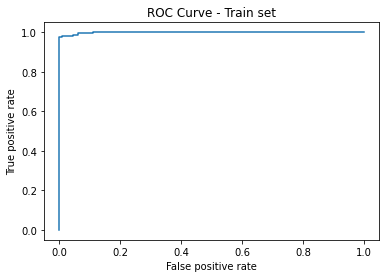

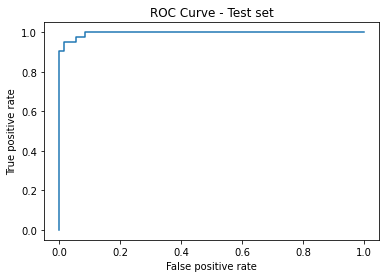

Confusion Matrix
Train set: [[285   0]
 [ 13 157]]
Test set: [[71  1]
 [ 3 39]]


In [9]:
# ROC curve and confusion matrix for the last run
print('ROC curve')
plot_roc_curve(cls_svm_best, df_wdbc_X_train_std, df_wdbc_y_train, title_name = 'ROC Curve - Train set')
plot_roc_curve(cls_svm_best, df_wdbc_X_test_std, df_wdbc_y_test, title_name = 'ROC Curve - Test set')
print('Confusion Matrix')
print('Train set:', confusion_matrix(df_wdbc_y_train, cls_svm_best.predict(df_wdbc_X_train_std)))
print('Test set:', confusion_matrix(df_wdbc_y_test, cls_svm_best.predict(df_wdbc_X_test_std)))

#### 1-(b)-ii. Semi-Supervised Learning/ Self-training: select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data. You can select them randomly.
> - A. Train an L1-penalized SVM to classify the labeled data Use normalized data. Choose the penalty parameter using 5 fold cross validation.
> - B. Find the unlabeled data point that is the farthest to the decision boundary of the SVM. Let the SVM label it (ignore its true label), and add it to the labeled data, and retrain the SVM. Continue this process until all unlabeled data are used. Test the final SVM on the test data andthe average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

In [10]:
df_result_semisup = pd.DataFrame(dtype = float, \
                             columns = ['iteration', 'train_test', 'accuracy', 'precision', 'recall', 'f1', 'auc'])


In [11]:
# train Semi-supervised L1-penalized SVM 30 times
for i in range(1, 31):
    
    # check progress
    if i % 5 == 0:
        print('iteration:', i)
    
    # split train/test - test size = 20% stratified
    df_wdbc_X_train, df_wdbc_X_test, df_wdbc_y_train, df_wdbc_y_test = train_test_split(df_wdbc_X, df_wdbc_y, \
                                                        test_size = 0.2, random_state = i, stratify = df_wdbc_y)
    
    # split labeled and unlabeled data from the training set
    df_wdbc_X_train_label, df_wdbc_X_train_unlabel, df_wdbc_y_train_label, df_wdbc_y_train_unlabel = \
                    train_test_split(df_wdbc_X_train, df_wdbc_y_train, \
                    test_size = 0.5, random_state = i, stratify = df_wdbc_y_train)
    
    while len(df_wdbc_X_train_unlabel) > 0:

        # standardize features
        scaler = StandardScaler()
        df_wdbc_X_train_std_label = scaler.fit_transform(df_wdbc_X_train_label)
        df_wdbc_X_train_std_unlabel = scaler.transform(df_wdbc_X_train_unlabel)

        # train SVM - L1 penalty - using 5 fold CV
        params = {'C': [1e-4, 1e-2, 1, 1e2, 1e4]}
        cls_svm_semi = LinearSVC(penalty = 'l1',  random_state = 0, dual = False, max_iter = 1e5)
        cls_svm_semi_cv = GridSearchCV(cls_svm_semi, params, cv = 5, scoring = 'accuracy')
        cls_svm_semi_cv.fit(df_wdbc_X_train_std_label, df_wdbc_y_train_label)

        # best SVM from CV
        cls_svm_semi_best = cls_svm_semi_cv.best_estimator_

        # distances to hyperplane of unlabeled data
        df_distance = pd.DataFrame({'dist': cls_svm_semi_best.decision_function(df_wdbc_X_train_std_unlabel)}, index = df_wdbc_X_train_unlabel.index)
        df_distance.loc[:, 'abs_dist'] = df_distance.loc[:, 'dist'].abs()
        df_distance.loc[:, 'class'] = df_distance.loc[:, 'dist'].apply(lambda x: 1 if x > 0 else 0)

        # rank distances
        df_distance.sort_values('abs_dist', ascending = False, inplace = True)

        # select unlabeled data with farthest distance from hyperplane - batch of 6
        conf_ind = df_distance[:6].index

        # add farthest unlabeled data to labeled data
        to_add_X = df_wdbc_X_train_unlabel.loc[conf_ind, :]
        to_add_y = df_distance.loc[:, 'class'][:6]
        df_wdbc_X_train_label = df_wdbc_X_train_label.append(to_add_X)
        df_wdbc_y_train_label = df_wdbc_y_train_label.append(to_add_y)

        # drop farthest unlabeled data
        df_wdbc_X_train_unlabel= df_wdbc_X_train_unlabel.drop(conf_ind)
        
        
    # train L1-penalized SVM again when all unlabeled data was labeled using SSL
    # standardize features
    scaler = StandardScaler()
    df_wdbc_X_train_std_label = scaler.fit_transform(df_wdbc_X_train_label)
    df_wdbc_X_test_std = scaler.transform(df_wdbc_X_test)

    # train SVM - L1 penalty - using 5 fold CV
    params = {'C': [1e-4, 1e-2, 1, 1e2, 1e4]}
    cls_svm_semi = LinearSVC(penalty = 'l1',  random_state = 0, dual = False, max_iter = 1e5)
    cls_svm_semi_cv = GridSearchCV(cls_svm_semi, params, cv = 5, scoring = 'accuracy')
    cls_svm_semi_cv.fit(df_wdbc_X_train_std_label, df_wdbc_y_train_label)
    
    
    # best SVM from CV
    cls_svm_semi_best = CalibratedClassifierCV(cls_svm_semi_cv.best_estimator_).fit(df_wdbc_X_train_std_label, df_wdbc_y_train_label)
    
    # calculate scores - training set
    train_acc = cls_svm_semi_best.score(df_wdbc_X_train_std_label, df_wdbc_y_train_label)
    train_prec = precision_score(df_wdbc_y_train_label, cls_svm_semi_best.predict(df_wdbc_X_train_std_label))
    train_rec = recall_score(df_wdbc_y_train_label, cls_svm_semi_best.predict(df_wdbc_X_train_std_label))
    train_f1 = f1_score(df_wdbc_y_train_label, cls_svm_semi_best.predict(df_wdbc_X_train_std_label))
    train_auc = roc_auc_score(df_wdbc_y_train_label, cls_svm_semi_best.predict_proba(df_wdbc_X_train_std_label)[:, 1])
    
    # calculate scores - testing set
    test_acc = cls_svm_semi_best.score(df_wdbc_X_test_std, df_wdbc_y_test)
    test_prec = precision_score(df_wdbc_y_test, cls_svm_semi_best.predict(df_wdbc_X_test_std))
    test_rec = recall_score(df_wdbc_y_test, cls_svm_semi_best.predict(df_wdbc_X_test_std))
    test_f1 = f1_score(df_wdbc_y_test, cls_svm_semi_best.predict(df_wdbc_X_test_std))
    test_auc = roc_auc_score(df_wdbc_y_test, cls_svm_semi_best.predict_proba(df_wdbc_X_test_std)[:, 1])
    
    # appending train/test scores
    df_result_semisup.loc[len(df_result_semisup), :] = [i, 'train', train_acc, train_prec, train_rec, train_f1, train_auc]
    df_result_semisup.loc[len(df_result_semisup), :] = [i, 'test', test_acc, test_prec, test_rec, test_f1, test_auc]
    

iteration: 5
iteration: 10
iteration: 15
iteration: 20
iteration: 25
iteration: 30


In [12]:
# average performance metrics over 30 runs
df_result_semisup.groupby('train_test')[['accuracy', 'precision', 'recall', 'f1', 'auc']].mean()

,accuracy,precision,recall,f1,auc
train_test,,,,,
test,0.955556,0.980865,0.897619,0.936591,0.990245
train,0.984322,0.999148,0.958551,0.978328,0.999465


ROC curve


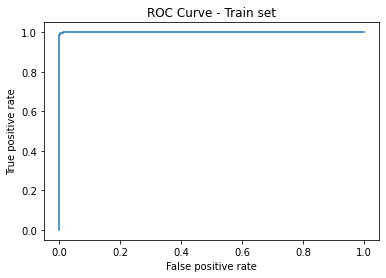

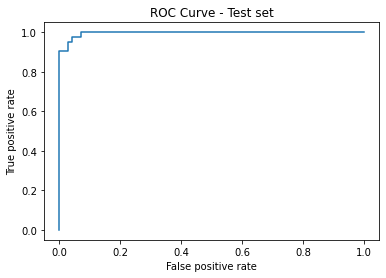

Confusion Matrix
Train set: [[286   2]
 [ 12 155]]
Test set: [[71  1]
 [ 3 39]]


In [13]:
# ROC curve and confusion matrix for the last run
print('ROC curve')
plot_roc_curve(cls_svm_semi_best, df_wdbc_X_train_std_label, df_wdbc_y_train_label, title_name = 'ROC Curve - Train set')
plot_roc_curve(cls_svm_semi_best, df_wdbc_X_test_std, df_wdbc_y_test, title_name = 'ROC Curve - Test set')
print('Confusion Matrix')
print('Train set:', confusion_matrix(df_wdbc_y_train_label, cls_svm_best.predict(df_wdbc_X_train_std_label)))
print('Test set:', confusion_matrix(df_wdbc_y_test, cls_svm_best.predict(df_wdbc_X_test_std)))


#### 1-(b)-iii. Unsupervised Learning: Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2.
> - A. Run the k-means algorithm multiple times. Make sure that you initialize the algoritm randomly. How do you make sure that the algorithm was not trapped in a local minimum?
> - B. Compute the centers of the two clusters and find the closest 30 data points to each center. Read the true labels of those 30 data points and take a majority poll within them. The majority poll becomes the label predicted by k-means for the members of each cluster. Then compare the labels provided by k-means with the true labels of the training data and report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs.
> - C. Classify test data based on their proximity to the centers of the clusters. Report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data

In [14]:
df_result_unsup = pd.DataFrame(dtype = float, \
                             columns = ['iteration', 'train_test', 'accuracy', 'precision', 'recall', 'f1', 'auc'])


> To avoid the algorithm trapped in a local minimum, we'll run K-means 25 times with different initializations 

In [15]:
# train Unsupervised K-means 30 times
for i in range(1, 2):
    
    # check progress
    if i % 5 == 0:
        print('iteration:', i)
    
    # split train/test - test size = 20% stratified
    df_wdbc_X_train, df_wdbc_X_test, df_wdbc_y_train, df_wdbc_y_test = train_test_split(df_wdbc_X, df_wdbc_y, \
                                                        test_size = 0.2, random_state = i, stratify = df_wdbc_y)
    
    # standardize features
    scaler = StandardScaler()
    df_wdbc_X_train_std = scaler.fit_transform(df_wdbc_X_train)
    df_wdbc_X_test_std = scaler.transform(df_wdbc_X_test)
    
    # train K-means multiple times to avoid local minimum
    best_km = None
    best_ch_score = 0
    for j in range(1, 26):
        # make random_state different each iteration
        km = KMeans(n_clusters = 2, init = 'random', random_state = j)
        km.fit(df_wdbc_X_train_std)
        ch_score = calinski_harabasz_score(df_wdbc_X_train_std, km.labels_)
        
        if ch_score > best_ch_score:
            best_km = km
            best_ch_score = ch_score
            
    # get distances to each data point's cluster
    df_km_result = pd.DataFrame(index = df_wdbc_X_train.index)
    df_km_result.loc[:, 'cluster_no'] = best_km.predict(df_wdbc_X_train_std)
    df_km_result.loc[:, 'distance'] = list(pd.DataFrame(best_km.transform(df_wdbc_X_train_std)).min(axis = 1))
        
    # select 30 data points closest to each cluster
    data_closest_cluster_30 = df_km_result.sort_values('distance',ascending = False).groupby('cluster_no').head(30).sort_values('cluster_no')
    
    # check labels - majority polling > to be used as label prediction for K-means
    data_closest_cluster_30.loc[:, 'label'] = df_wdbc_y_train
    predicted_label = data_closest_cluster_30.groupby('cluster_no')['label'].agg(pd.Series.mode)
    
    # get assigned cluster for train and test data
    assigned_train = best_km.predict(df_wdbc_X_train_std)
    assigned_test = best_km.predict(df_wdbc_X_test_std)
    
    # get prediction for train and test set
    y_pred_train = pd.Series(assigned_train).map(predicted_label)
    y_pred_test = pd.Series(assigned_test).map(predicted_label)
    
    # get prediction probability to be in each cluster (using 1 - softmax from distance from cluster's center)
    prob_in_cluster_train = 1 - softmax(best_km.transform(df_wdbc_X_train_std), axis = 1)
    prob_in_cluster_test = 1 - softmax(best_km.transform(df_wdbc_X_test_std), axis = 1)
    
    # get probability of being in class 1
    y_pred_proba_train = pd.DataFrame(prob_in_cluster_train).iloc[:, [cluster_no for cluster_no, label in predicted_label.iteritems() if label == 1]].sum(axis = 1)
    y_pred_proba_test = pd.DataFrame(prob_in_cluster_test).iloc[:, [cluster_no for cluster_no, label in predicted_label.iteritems() if label == 1]].sum(axis = 1)
    
    # calculate scores - training set
    train_acc = accuracy_score(df_wdbc_y_train, y_pred_train)
    train_prec = precision_score(df_wdbc_y_train, y_pred_train)
    train_rec = recall_score(df_wdbc_y_train, y_pred_train)
    train_f1 = f1_score(df_wdbc_y_train, y_pred_train)
    train_auc = roc_auc_score(df_wdbc_y_train, y_pred_proba_train)
    
    # calculate scores - testing set
    test_acc = accuracy_score(df_wdbc_y_test, y_pred_test)
    test_prec = precision_score(df_wdbc_y_test, y_pred_test)
    test_rec = recall_score(df_wdbc_y_test, y_pred_test)
    test_f1 = f1_score(df_wdbc_y_test, y_pred_test)
    test_auc = roc_auc_score(df_wdbc_y_test, y_pred_proba_test)
    
    # appending train/test scores
    df_result_unsup.loc[len(df_result_unsup), :] = [i, 'train', train_acc, train_prec, train_rec, train_f1, train_auc]
    df_result_unsup.loc[len(df_result_unsup), :] = [i, 'test', test_acc, test_prec, test_rec, test_f1, test_auc]
    
    
    

In [16]:
# average performance metrics over 30 runs
df_result_unsup.groupby('train_test')[['accuracy', 'precision', 'recall', 'f1', 'auc']].mean()

,accuracy,precision,recall,f1,auc
train_test,,,,,
test,0.921053,0.945946,0.833333,0.886076,0.975529
train,0.903297,0.914474,0.817647,0.863354,0.972590


ROC curve


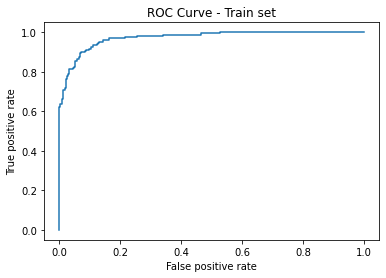

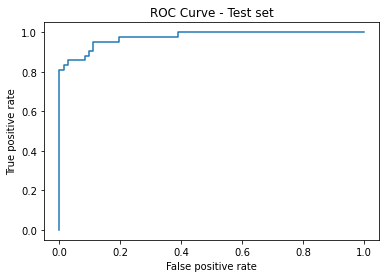

Confusion Matrix
Train set: [[272  13]
 [ 31 139]]
Test set: [[70  2]
 [ 7 35]]


In [17]:
# ROC curve and confusion matrix for the last run
print('ROC curve')
# roc curve for train set
fpr, tpr, thresholds = roc_curve(df_wdbc_y_train, y_pred_proba_train)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve - Train set')
plt.show()   

# roc curve for test set
fpr, tpr, thresholds = roc_curve(df_wdbc_y_test, y_pred_proba_test)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve - Test set')
plt.show() 

print('Confusion Matrix')
print('Train set:', confusion_matrix(df_wdbc_y_train, y_pred_train))
print('Test set:', confusion_matrix(df_wdbc_y_test, y_pred_test))


#### 1-(b)-iv. Spectral Clustering: Repeat 1(b)iii using spectral clustering, which is clus- tering based on kernels.3 Research what spectral clustering is. Use RBF kernel with gamma=1 or find a gamma for which the two clutsres have the same balance as the one in original data set (if the positive class has p and the negative class has n samples, the two clusters must have p and n members). Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters . Instead, use fit − predict method.

In [41]:
# functions for Spectral Clustering - prediction for new instances using K-nearest neighbors
def spectral_predict(df_X, df_predicted_label, df_new_instances, n = 30):
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(df_X, df_predicted_label)
    return knn.predict(df_new_instances)

def spectral_predict_proba(df_X, df_predicted_label, df_new_instances, n = 30):
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(df_X, df_predicted_label)
    return knn.predict_proba(df_new_instances)[:, 1]

In [42]:
df_result_spectral = pd.DataFrame(dtype = float, \
                             columns = ['iteration', 'train_test', 'accuracy', 'precision', 'recall', 'f1', 'auc'])


In [43]:
# train Spectral Clustering 30 times
for i in range(1, 31):
    
    # check progress
    if i % 5 == 0:
        print('iteration:', i)
    
    # split train/test - test size = 20% stratified
    df_wdbc_X_train, df_wdbc_X_test, df_wdbc_y_train, df_wdbc_y_test = train_test_split(df_wdbc_X, df_wdbc_y, \
                                                        test_size = 0.2, random_state = 0, stratify = df_wdbc_y)
    
    # standardize features
    scaler = StandardScaler()
    df_wdbc_X_train_std = scaler.fit_transform(df_wdbc_X_train)
    df_wdbc_X_test_std = scaler.transform(df_wdbc_X_test)
    
    # train Spectral Clustering - initializing multiple times using n_init - use gamma = 0.01 to have similar division of samples as labeled data
    sp = SpectralClustering(n_clusters = 2, gamma = 0.01, affinity = 'rbf', assign_labels = 'discretize', random_state = i, n_init = 10)
    sp.fit_predict(df_wdbc_X_train_std)
            
    # get predicted label from majority polling within each cluster
    df_spectral = pd.DataFrame(df_wdbc_y_train.copy().values, columns = ['label'])
    df_spectral['cluster_no'] = sp.labels_
    predicted_label = df_spectral.groupby('cluster_no')['label'].agg(pd.Series.mode)
    
    df_predicted_label = df_wdbc_y_train.map(predicted_label)
    
    # get prediction for train and test set
    y_pred_train = spectral_predict(df_wdbc_X_train_std, df_predicted_label, df_wdbc_X_train_std, n = 10)
    y_pred_test = spectral_predict(df_wdbc_X_train_std, df_predicted_label, df_wdbc_X_test_std, n = 10)
    
    # get probability of being in class 1
    y_pred_proba_train = spectral_predict_proba(df_wdbc_X_train_std, df_predicted_label, df_wdbc_X_train_std, n = 10)
    y_pred_proba_test = spectral_predict_proba(df_wdbc_X_train_std, df_predicted_label, df_wdbc_X_test_std, n = 10)
    
    # calculate scores - training set
    train_acc = accuracy_score(df_wdbc_y_train, y_pred_train)
    train_prec = precision_score(df_wdbc_y_train, y_pred_train)
    train_rec = recall_score(df_wdbc_y_train, y_pred_train)
    train_f1 = f1_score(df_wdbc_y_train, y_pred_train)
    train_auc = roc_auc_score(df_wdbc_y_train, y_pred_proba_train)
    
    # calculate scores - testing set
    test_acc = accuracy_score(df_wdbc_y_test, y_pred_test)
    test_prec = precision_score(df_wdbc_y_test, y_pred_test)
    test_rec = recall_score(df_wdbc_y_test, y_pred_test)
    test_f1 = f1_score(df_wdbc_y_test, y_pred_test)
    test_auc = roc_auc_score(df_wdbc_y_test, y_pred_proba_test)
    
    # appending train/test scores
    df_result_spectral.loc[len(df_result_spectral), :] = [i, 'train', train_acc, train_prec, train_rec, train_f1, train_auc]
    df_result_spectral.loc[len(df_result_spectral), :] = [i, 'test', test_acc, test_prec, test_rec, test_f1, test_auc]
    
    
    

iteration: 5
iteration: 10
iteration: 15
iteration: 20
iteration: 25
iteration: 30


In [44]:
# average performance metrics over 30 runs
df_result_spectral.groupby('train_test')[['accuracy', 'precision', 'recall', 'f1', 'auc']].mean()

,accuracy,precision,recall,f1,auc
train_test,,,,,
test,0.717544,0.689900,0.711111,0.699806,0.728549
train,0.717802,0.743277,0.690196,0.714457,0.731831


ROC curve


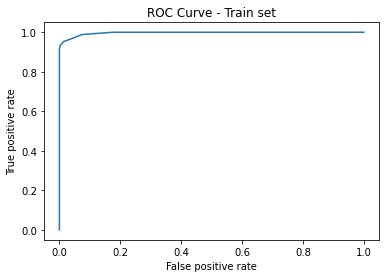

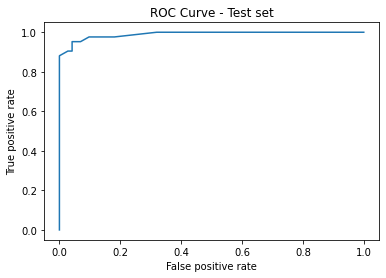

Confusion Matrix
Train set: [[285   0]
 [ 14 156]]
Test set: [[69  3]
 [ 2 40]]


In [45]:
# ROC curve and confusion matrix for the last run
print('ROC curve')
# roc curve for train set
fpr, tpr, thresholds = roc_curve(df_wdbc_y_train, y_pred_proba_train)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve - Train set')
plt.show()   

# roc curve for test set
fpr, tpr, thresholds = roc_curve(df_wdbc_y_test, y_pred_proba_test)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve - Test set')
plt.show() 

print('Confusion Matrix')
print('Train set:', confusion_matrix(df_wdbc_y_train, y_pred_train))
print('Test set:', confusion_matrix(df_wdbc_y_test, y_pred_test))


> - It turns out that using Spectral Clustering gives significantly worse results than K-means.
> - Investigated and found out that some of the iterations have the predicted labels (calculated from the mode of the data within clusters) differently, and these iterations result in very poor test accuracy ~ 5%. For the majority of the iterations that (seems to) have the correct predicted labels, the test accuracy is as high as ~90+%.

#### 1-(b)-v. One can expect that supervised learning on the full data set works better than semi-supervised learning with half of the data set labeled.One can expect that unsupervised learning underperforms in such situations. Compare the results you obtained by those methods.

In [23]:
print('----- Results from Supervised Learning -----')
display(df_result_sup.groupby('train_test')[['accuracy', 'precision', 'recall', 'f1', 'auc']].mean())
print('----- Results from Semi-Supervised Learning -----')
display(df_result_semisup.groupby('train_test')[['accuracy', 'precision', 'recall', 'f1', 'auc']].mean())
print('----- Results from Unsupervised Learning -----')
display(df_result_unsup.groupby('train_test')[['accuracy', 'precision', 'recall', 'f1', 'auc']].mean())

----- Results from Supervised Learning -----


,accuracy,precision,recall,f1,auc
train_test,,,,,
test,0.961696,0.990928,0.904762,0.945293,0.993188
train,0.975311,0.996862,0.936863,0.965874,0.997662


----- Results from Semi-Supervised Learning -----


,accuracy,precision,recall,f1,auc
train_test,,,,,
test,0.955556,0.980865,0.897619,0.936591,0.990245
train,0.984322,0.999148,0.958551,0.978328,0.999465


----- Results from Unsupervised Learning -----


,accuracy,precision,recall,f1,auc
train_test,,,,,
test,0.921053,0.945946,0.833333,0.886076,0.975529
train,0.903297,0.914474,0.817647,0.863354,0.972590


> As expected, the performance of supervised learning is the best, followed by the semi-supervised learning where it only performs slightly worse than supervised learning, and the unsupervised learning performs the worst.

# 2. Active Learning Using Support Vector Machines

#### 2-(a). Download the banknote authentication Data Set from: https://archive.ics.uci.edu/ml/datasets/banknote+authentication. Choose 472 data points ran- domly as the test set, and the remaining 900 points as the training set. This is a binary classification problem.

In [24]:
# read data from file
df_bn = pd.read_csv('../data/data_banknote_authentication.txt', names = ['variance', 'skewness', 'curtosis', 'entropy', 'label'])
display(df_bn.head())

,variance,skewness,curtosis,entropy,label
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [25]:
# define X and y
df_bn_X = df_bn.loc[:, df_bn.columns != 'label']
df_bn_y = df_bn.loc[:, 'label']

In [26]:
# ignore warnings when number of samples are low (warning from GridSearchCV with cv = 5)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = FitFailedWarning)

### 2-(b). Repeat each of the following two procedures 50 times. You will have 50 errors for 90 SVMs per each procedure.

#### 2-(b)-i. Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Select the penalty parameter using 5-fold cross validation.4 Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points. Do NOT replace the samples back into the training set at each step. Calculate the test error for each SVM. You will have 90 SVMs that were trained using 10, 20, 30, ... , 900 data points and their 90 test errors. You have implemented passive learning.

In [27]:
df_result_passive = pd.DataFrame(columns = ['iteration', 'num_samples', 'training_err', 'testing_err'], dtype = float)


In [28]:
# 50 iterations of passive learning
for i in range(1, 51):
    
    # check progress
    if i % 5 == 0:
        print('iteration:', i)
        
    # split train / test
    df_bn_X_train, df_bn_X_test, df_bn_y_train, df_bn_y_test = train_test_split(df_bn_X, df_bn_y, \
                                                        test_size = 472, random_state = i, stratify = df_bn_y)
    
    ### passive learning 90 times - increasing num samples
    
    # define initial traning set that is selected or not
    df_bn_X_train_selected = pd.DataFrame(columns = df_bn_X_train.columns)
    df_bn_y_train_selected = pd.Series(dtype = int)
    df_bn_X_train_not_selected = df_bn_X_train.copy()
    df_bn_y_train_not_selected = df_bn_y_train.copy()
    
    
    ## start PASSIVE LEARNING by adding randomly select 10 samples (90 iterations)
    for j in range(1, 91):
    
        # randomly select 10 data points
        rand_data = df_bn_X_train_not_selected.sample(n = 10, random_state = 0)
    
        # append randomly selected data to training set and remove from non-selected df
        df_bn_X_train_selected = df_bn_X_train_selected.append(rand_data)
        df_bn_y_train_selected = df_bn_y_train_selected.append(df_bn_y_train_not_selected[rand_data.index])

        df_bn_X_train_not_selected = df_bn_X_train_not_selected.drop(index = rand_data.index)
        df_bn_y_train_not_selected = df_bn_y_train_not_selected.drop(index = rand_data.index)
        
        # skip if selected samples are from only one class
        if len(df_bn_y_train_selected.drop_duplicates()) == 1:
            continue
        
        # standardize data
        scaler = StandardScaler()
        df_bn_X_train_selected_std = scaler.fit_transform(df_bn_X_train_selected)
        df_bn_X_test_std = scaler.transform(df_bn_X_test)
        
        # train with 5-fold CV
        params = {'C': [1e-4, 1e-2, 1, 1e2, 1e4]}
        cls_svm = LinearSVC(penalty = 'l1',  random_state = 0, dual = False, max_iter = 1e5)
        cls_svm_cv = GridSearchCV(cls_svm, params, cv = 5, scoring = 'accuracy')
        x_sort = pd.DataFrame(df_bn_X_train_selected_std, index = df_bn_X_train_selected.index).sort_index()
        y_sort = pd.DataFrame(df_bn_y_train_selected).sort_index()
        cls_svm_cv.fit(x_sort, y_sort)
        
        # best SVM from CV
        cls_svm_best = cls_svm_cv.best_estimator_
    
        # find errors
        train_err = 1 - cls_svm_best.score(df_bn_X_train_selected_std, df_bn_y_train_selected)
        test_err = 1 - cls_svm_best.score(df_bn_X_test_std, df_bn_y_test)

        # append results of first run to df
        df_result_passive.loc[len(df_result_passive), :] = [i, j * 10, train_err, test_err]

    

iteration: 5
iteration: 10
iteration: 15
iteration: 20
iteration: 25
iteration: 30
iteration: 35
iteration: 40
iteration: 45
iteration: 50


In [29]:
df_result_passive_grouped = df_result_passive.groupby('num_samples')[['training_err', 'testing_err']].mean()

#### 2-(b)-ii. Train a SVM with a pool of 10 randomly selected data points from the training set5 using linear kernel and L1 penalty. Select the parameters of the SVM with 5-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM6 and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool. Repeat this process until all training data is used. You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have implemented active learning.

In [30]:
df_result_active = pd.DataFrame(columns = ['iteration', 'num_samples', 'training_err', 'testing_err'], dtype = float)


In [31]:
# 50 iterations of active learning
for i in range(1, 51):
    
    # check progress
    if i % 5 == 0:
        print('iteration:', i)
    
    # split train / test
    df_bn_X_train, df_bn_X_test, df_bn_y_train, df_bn_y_test = train_test_split(df_bn_X, df_bn_y, \
                                                        test_size = 472, random_state = i, stratify = df_bn_y)
    
    ### active learning 90 times - increasing num samples
    
    # define initial training set that is selected or not
    df_bn_X_train_selected = pd.DataFrame(columns = df_bn_X_train.columns)
    df_bn_y_train_selected = pd.Series(dtype = int)
    df_bn_X_train_not_selected = df_bn_X_train.copy()
    df_bn_y_train_not_selected = df_bn_y_train.copy()
    
    cls_svm_best = None
    
    ## start ACTIVE LEARNING by adding data points closest to hyperplanes (90 iterations)
    for j in range(1, 91):
        
        # select 10 samples either randomly or those closest to hyperplane
        if len(df_bn_X_train_selected) == 0 or cls_svm_best is None:
            # randomly select 10 data points for the first run
            rand_data = df_bn_X_train_not_selected.sample(n = 10, random_state = 0)

            # append randomly selected data to training set and remove from non-selected df
            df_bn_X_train_selected = df_bn_X_train_selected.append(rand_data)
            df_bn_y_train_selected = df_bn_y_train_selected.append(df_bn_y_train_not_selected[rand_data.index])

            df_bn_X_train_not_selected = df_bn_X_train_not_selected.drop(rand_data.index)
            df_bn_y_train_not_selected = df_bn_y_train_not_selected.drop(rand_data.index)
        
        else:
            
            # find distances of unselected data points
            df_distance = pd.DataFrame({'dist': cls_svm_best.decision_function(df_bn_X_train_not_selected)}, index = df_bn_X_train_not_selected.index)
            df_distance.loc[:, 'abs_dist'] = df_distance.loc[:, 'dist'].abs()

            # select 10 data points closest to the hyperplane
            closest_data_points = df_distance.nsmallest(columns = 'abs_dist', n = 10)

            # add the selected data points to training set and remove from unselected list
            df_bn_X_train_selected = df_bn_X_train_selected.append(df_bn_X_train_not_selected.loc[closest_data_points.index, :])
            df_bn_y_train_selected = df_bn_y_train_selected.append(df_bn_y_train_not_selected[closest_data_points.index])

            df_bn_X_train_not_selected = df_bn_X_train_not_selected.drop(index = closest_data_points.index)
            df_bn_y_train_not_selected = df_bn_y_train_not_selected.drop(index = closest_data_points.index)
        
        # skip if selected samples are from only one class
        if len(df_bn_y_train_selected.drop_duplicates()) == 1:
            continue
        
        # standardize data
        scaler = StandardScaler()
        df_bn_X_train_selected_std = scaler.fit_transform(df_bn_X_train_selected)
        df_bn_X_test_std = scaler.transform(df_bn_X_test)
        
        # train the model with 5-fold CV
        params = {'C': [1e-4, 1e-2, 1, 1e2, 1e4]}
        cls_svm = LinearSVC(penalty = 'l1',  random_state = 0, dual = False, max_iter = 1e5)
        cls_svm_cv = GridSearchCV(cls_svm, params, cv = 5, scoring = 'accuracy')
        x_sort = pd.DataFrame(df_bn_X_train_selected_std, index = df_bn_X_train_selected.index).sort_index()
        y_sort = pd.DataFrame(df_bn_y_train_selected).sort_index()
        cls_svm_cv.fit(x_sort, y_sort)
        
        # best SVM from CV
        cls_svm_best = cls_svm_cv.best_estimator_

        # find errors
        train_err = 1 - cls_svm_best.score(df_bn_X_train_selected_std, df_bn_y_train_selected)
        test_err = 1 - cls_svm_best.score(df_bn_X_test_std, df_bn_y_test)

        # append results to df
        df_result_active.loc[len(df_result_active), :] = [i, j * 10, train_err, test_err]
        
        

iteration: 5
iteration: 10
iteration: 15
iteration: 20
iteration: 25
iteration: 30
iteration: 35
iteration: 40
iteration: 45
iteration: 50


In [32]:
df_result_active_grouped = df_result_active.groupby('num_samples')[['training_err', 'testing_err']].mean()

### 2-(c). Average the 50 test errors for each of the incrementally trained 90 SVMs in 2(b)i and 2(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot average test error versus number of training instances for both active and passive learners on the same figure and report your conclusions. Here, you are actually obtaining a learning curve by Monte-Carlo simulation.

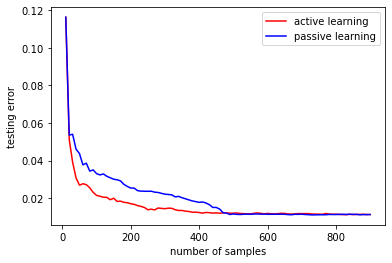

In [33]:
# plot average test errors vs number of traning instances for both active and passive learnings
plt.plot(df_result_passive_grouped.index, df_result_passive_grouped['testing_err'], c = 'r', label = 'active learning')
plt.plot(df_result_active_grouped.index, df_result_active_grouped['testing_err'], c = 'b', label = 'passive learning')
plt.xlabel('number of samples')
plt.ylabel('testing error')
plt.legend()
plt.show()


> We see that at the same number of samples used to train the model, active learner is able to achieve lower testing error compared to passive learner